In [1]:
import os

import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
df = df.sample(n=100)
print(df.shape)
df.head()

(100, 15)


,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
4685933,7,83,414,821,82.36,28200.0,10.0,110.36,2013.07,517.0,50.0,1132.0,845.0,2016,6
3253565,3,139,1161,11311,85.05,9500.0,5.0,109.09,1997.09,298.0,114.0,369.0,288.0,2006,7
6081967,16,192,1344,13331,59.40,10350.0,10.0,76.03,2003.07,856.0,60.0,576.0,450.0,2009,8
6118988,16,197,1340,2796,52.72,7600.0,3.0,62.81,1994.12,290.0,290.0,477.0,400.0,2013,6
5573406,11,128,490,4173,59.30,16950.0,2.0,79.34,1994.06,930.0,930.0,945.0,706.0,2009,4


In [5]:
y = df['price']
del df['price']

In [6]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [7]:
lightgbm = lgb.LGBMRegressor(random_state=0)

In [8]:
kfold = KFold(n_splits=5, random_state=0).get_n_splits(x_train.values)
cross_val_score(lightgbm, x_train.values, y_train)

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([-0.45285713,  0.361707  ,  0.47608371])

In [9]:
lightgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
modelPred = lightgbm.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

14972.520741892034

In [11]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 35100.000, 예상가격: 36077.985
실제가격: 11800.000, 예상가격: 12636.793
실제가격: 10350.000, 예상가격: 19033.096
실제가격: 3200.000, 예상가격: 1626.611
실제가격: 24500.000, 예상가격: 59751.937
실제가격: 18970.000, 예상가격: 39163.835
실제가격: 19700.000, 예상가격: 9323.951
실제가격: 21350.000, 예상가격: 24584.309
실제가격: 9300.000, 예상가격: 15812.739
실제가격: 34500.000, 예상가격: 49894.130


In [12]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [14]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [15]:
history = model.fit(x_train, y_train, validation_split=0.4, epochs=100, batch_size=1000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 42 samples, validate on 28 samples
Epoch 1/100
42/42 [==============================] - 2s 45ms/step - loss: 753656768.0000 - acc: 0.0000e+00 - val_loss: 2758972672.0000 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2758972672.00000, saving model to ./model/01-2758972672.0000.hdf5
Epoch 2/100
42/42 [==============================] - 0s 214us/step - loss: 745973568.0000 - acc: 0.0000e+00 - val_loss: 2746057984.0000 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 2758972672.00000 to 2746057984.00000, saving model to ./model/02-2746057984.0000.hdf5
Epoch 3/100
42/42 [==============================] - 0s 191us/step - loss: 737959040.0000 - acc: 0.0000e+00 - val_loss: 2732974080.0000 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 2746057984.00000 to 2732974080.00000, saving model to ./model/03-2732974080.0000.hdf5
Epoch 4/100
42/42 [==============================] - 0s 214us/step - loss: 7296

Epoch 29/100
42/42 [==============================] - 0s 143us/step - loss: 428158592.0000 - acc: 0.0000e+00 - val_loss: 2120774400.0000 - val_acc: 0.0000e+00

Epoch 00029: val_loss improved from 2151376640.00000 to 2120774400.00000, saving model to ./model/29-2120774400.0000.hdf5
Epoch 30/100
42/42 [==============================] - 0s 119us/step - loss: 414758048.0000 - acc: 0.0000e+00 - val_loss: 2089861248.0000 - val_acc: 0.0000e+00

Epoch 00030: val_loss improved from 2120774400.00000 to 2089861248.00000, saving model to ./model/30-2089861248.0000.hdf5
Epoch 31/100
42/42 [==============================] - 0s 119us/step - loss: 401554976.0000 - acc: 0.0000e+00 - val_loss: 2058746624.0000 - val_acc: 0.0000e+00

Epoch 00031: val_loss improved from 2089861248.00000 to 2058746624.00000, saving model to ./model/31-2058746624.0000.hdf5
Epoch 32/100
42/42 [==============================] - 0s 167us/step - loss: 388580512.0000 - acc: 0.0000e+00 - val_loss: 2027553408.0000 - val_acc: 0.0000


Epoch 00058: val_loss improved from 1516892928.00000 to 1513938688.00000, saving model to ./model/58-1513938688.0000.hdf5
Epoch 59/100
42/42 [==============================] - 0s 143us/step - loss: 225779072.0000 - acc: 0.0000e+00 - val_loss: 1512002432.0000 - val_acc: 0.0000e+00

Epoch 00059: val_loss improved from 1513938688.00000 to 1512002432.00000, saving model to ./model/59-1512002432.0000.hdf5
Epoch 60/100
42/42 [==============================] - 0s 143us/step - loss: 221865280.0000 - acc: 0.0000e+00 - val_loss: 1510814720.0000 - val_acc: 0.0000e+00

Epoch 00060: val_loss improved from 1512002432.00000 to 1510814720.00000, saving model to ./model/60-1510814720.0000.hdf5
Epoch 61/100
42/42 [==============================] - 0s 119us/step - loss: 217837200.0000 - acc: 0.0000e+00 - val_loss: 1510298880.0000 - val_acc: 0.0000e+00

Epoch 00061: val_loss improved from 1510814720.00000 to 1510298880.00000, saving model to ./model/61-1510298880.0000.hdf5
Epoch 62/100
42/42 [===========

Epoch 91/100
42/42 [==============================] - 0s 143us/step - loss: 118069544.0000 - acc: 0.0000e+00 - val_loss: 1445521408.0000 - val_acc: 0.0000e+00

Epoch 00091: val_loss improved from 1449313920.00000 to 1445521408.00000, saving model to ./model/91-1445521408.0000.hdf5
Epoch 92/100
42/42 [==============================] - 0s 143us/step - loss: 115859112.0000 - acc: 0.0000e+00 - val_loss: 1442018176.0000 - val_acc: 0.0000e+00

Epoch 00092: val_loss improved from 1445521408.00000 to 1442018176.00000, saving model to ./model/92-1442018176.0000.hdf5
Epoch 93/100
42/42 [==============================] - 0s 119us/step - loss: 113740048.0000 - acc: 0.0000e+00 - val_loss: 1438788352.0000 - val_acc: 0.0000e+00

Epoch 00093: val_loss improved from 1442018176.00000 to 1438788352.00000, saving model to ./model/93-1438788352.0000.hdf5
Epoch 94/100
42/42 [==============================] - 0s 119us/step - loss: 111711440.0000 - acc: 0.0000e+00 - val_loss: 1435892480.0000 - val_acc: 0.0000

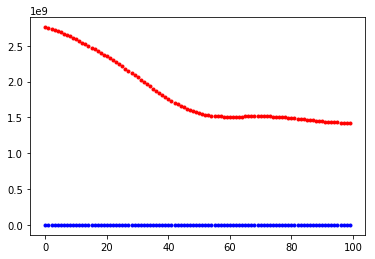

In [16]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [17]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

9510.606107599297

In [18]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 35100.000, 예상가격: 23061.574
실제가격: 11800.000, 예상가격: 21718.213
실제가격: 10350.000, 예상가격: 20429.951
실제가격: 3200.000, 예상가격: 17327.305
실제가격: 24500.000, 예상가격: 22467.342
실제가격: 18970.000, 예상가격: 17990.033
실제가격: 19700.000, 예상가격: 24466.350
실제가격: 21350.000, 예상가격: 24449.775
실제가격: 9300.000, 예상가격: 22476.664
실제가격: 34500.000, 예상가격: 23740.400
